In [1]:
##### Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split

#Import Keras packages for neural network design
from keras.models import Sequential
from tensorflow.keras import layers,losses
from keras.layers import Dense, Input, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, MaxPool2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.models import Model, load_model
from keras import regularizers
from sklearn.utils import shuffle

from imgaug import augmenters
from random import randint

2023-01-13 14:34:20.647743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Set a random seed for reproducibility.
np.random.seed(42)

In [3]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def plot_me(x_data, y_data, title, x_name, y_name):
    plt.barh(y_data, x_data)
    plt.title(title)
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.show()
    
def get_count(dict_labels, labels):
    counts_labels = []
    counts = []
    for x in range(len(dict_labels)):
        counts_labels.append(dict_labels[x])
        cat_count = np.count_nonzero(labels == x)
        counts.append(cat_count)
    return (counts, counts_labels)

# we are splitting training to training and validation
def shuffle_and_inspect(dict_labels, x_data, y_data, data_set):
    print("Shuffling")
    xs_data, ys_data = shuffle(x_data, y_data)
    # print(f'xs_data, ys_data: {xs_data, ys_data}')
    counts, counts_labels = get_count(labeldict, ys_data)
    # print(f'data set: {data_set}') # training data after split
    plot_me(counts, counts_labels, data_set, "Number of elements in category", "Category") 
    return (xs_data, ys_data)

# we want to find acceptable variance, explained below
def variance(X): 
    mean = sum (X) / len (X)
    tot = 0.0
    for x in X:
        tot = tot + (x - mean) ** 2
    return tot / len (X)
    # call the function with data set.

def detailed_inspect(x_data, y_data):
    print("#################")
    counts, counts_labels = get_count(labeldict, y_data)
    print(f'Counts and counts labels: {counts, counts_labels}')
    print("Variance: ", variance(counts)) # call variance
    # WHY WE NEED MAX and MIN?
    print("max: ", max(counts))
    print("min: ", min(counts))
    print("max-min: ", max(counts) - min(counts))
    print("#################")



In [4]:
FIND_VARIANCE_LOOP = 10
ACCEPTABLE_VARIANCE = 0
"""
Method takes in the training set, and splits it to training and validation set.
Sometimes the split method from sklearn is splitting the data with quite high variance, so we sometimes 
had the training set with a lot less t-shirts and validation set with a lot of t-shirts for example.

In order to try and minimize the variance, we set an acceptable amount of variance, and a maximum loop count.
We then split the data, until an acceptable variance is reached or until we've reached our max loop count.

If the max loop count is reached, we'll throw an error here with some details about what results we got from the splits.
"""
# equal distirbution
def get_acceptable_split(x_train, y_train):
    print("Splitting data up to ", FIND_VARIANCE_LOOP, " times, or until acceptable variance (", ACCEPTABLE_VARIANCE,") is found.")
    i = 0
    vars_found = []
    acceptable_var_found = False
    while i < FIND_VARIANCE_LOOP:
        i+=1
        ## Split train set into train and validation (16,666% validation = 10000 images)
        
        # stratify parameter will preserve the proportion of target as in original dataset
        s_x_train, x_val, s_y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.16666)
        
        # ... Every day I'm shuffling
        
        # or above with shuffle = True randomly shuffle before being split 
        s_x_train, s_y_train = shuffle(s_x_train, s_y_train)
        
        # Get count of each category of clothing in the validation set:
        counts, counts_labels = get_count(labeldict, y_val)
        
        # Get variance ("spread") of the catagorized data
        # variance will be the same for val and train, and val is smaller so we'll use that
        val_variance = variance(counts)
        
        vars_found.append(val_variance) # Add variance found to a list in case startification didn't work
        
        # Set boolean variable to True if our acceptable variance limit was met
        # Originally made before we were using stratification when splitting the dataset, but decided to keep it
        # in case stratification were to fail - throwing an error if we don't get 0 variance.
        acceptable_var_found = val_variance <= ACCEPTABLE_VARIANCE
        if(acceptable_var_found):
            print("Acceptable variance found: ", val_variance)
            print("We looped ", i, " times to find it!")
            x_train = s_x_train
            y_train = s_y_train
            i=FIND_VARIANCE_LOOP
            acceptable_var = True
    
    if(acceptable_var_found == False):
        min_found = min(vars_found)
        msg = "Couldn't find acceptable variance."
        stats = "Loop count: ", FIND_VARIANCE_LOOP, ", best variance found: ", min_found, ", but acceptable is set to: ", ACCEPTABLE_VARIANCE 
        instructions = "Try setting the loop count to be higher (FIND_VARIANCE_LOOP), or lower the ACCEPTABLE_VARIANCE, or just try running it again"
        raise Exception(msg, stats, instructions)
    
    return ((x_train, y_train), (x_val, y_val))

In [5]:
def get_and_split_data():
    #Load in the Fashion MNIST data set.
    
    print("Fetching data")
    from keras.datasets import fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
   

    # Get split data with acceptable variance
    (x_train, y_train), (x_val, y_val) = get_acceptable_split(x_train, y_train)
    
    print("Training set after splitting:")
    x_train, y_train = shuffle_and_inspect(labeldict, x_train, y_train, "Training data after split")
    
    print("Lets get a few more details of the training set: ")
    detailed_inspect(x_train, y_train)
    
    print("Validation set:")
    x_val, y_val = shuffle_and_inspect(labeldict, x_val, y_val, "Validation data")

    print("Lets get a few more details of the validation set: ")
    detailed_inspect(x_val, y_val)
    
    print("In get and split data we have these shapes:")
    print("x train: ", x_train.shape) # it wil have 28, 28 pixels
    print("y train: ", y_train.shape) # target, output variable we want to predict
    print("x val:   ", x_val.shape)
    print("y val:   ",  y_val.shape)
    print("x test:  ", x_test.shape)
    print("y test:  ", y_test.shape)
    return ((x_train, y_train), (x_val, y_val), (x_test, y_test))

Fetching data
Splitting data up to  10  times, or until acceptable variance ( 0 ) is found.
Acceptable variance found:  0.0
We looped  1  times to find it!
Training set after splitting:
Shuffling


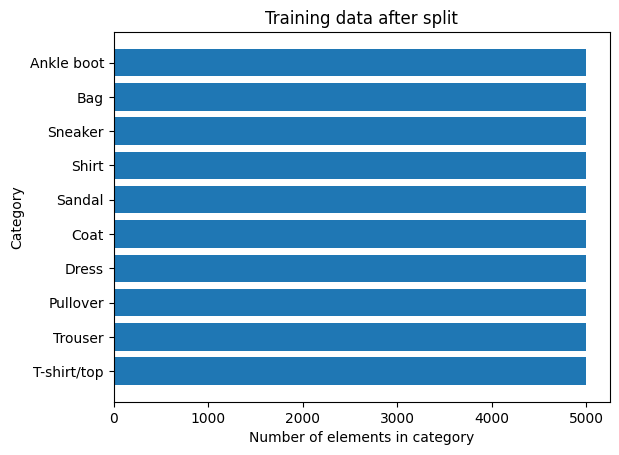

Lets get a few more details of the training set: 
#################
Counts and counts labels: ([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000], ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
Variance:  0.0
max:  5000
min:  5000
max-min:  0
#################
Validation set:
Shuffling


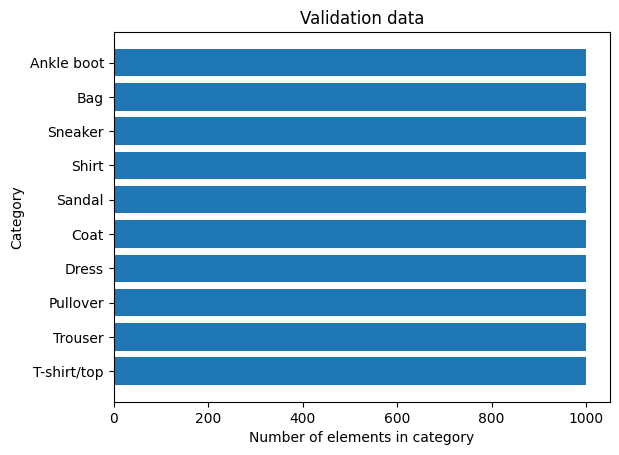

Lets get a few more details of the validation set: 
#################
Counts and counts labels: ([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
Variance:  0.0
max:  1000
min:  1000
max-min:  0
#################
In get and split data we have these shapes:
x train:  (50000, 28, 28)
y train:  (50000,)
x val:    (10000, 28, 28)
y val:    (10000,)
x test:   (10000, 28, 28)
y test:   (10000,)


In [6]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_and_split_data()

In [17]:
def shape_cnn_data():   
    """ 
     Depth 1 reshape is reshapig to grayscale, and to a single-channel image by flattening the 
     multi-dimensional array into a one-dimensional array. Image classification moddels are designed to process one-dimensional data.
     Perhaps unnecessary with Fashion MNIST, but scaling like this is best practice with image data.
     It also may improve computation efficiency.
    """
    cnn_x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    cnn_x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
    cnn_x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    
    """
      The pixel values of the images are integers between 0 and 255.
      Dividing the pixel values by 255 is a common way to normalize image data.
      It scales the pixel values to a range of 0 to 1, which is
      a more manageable range for machine learning models.
    
    """
    cnn_x_train = cnn_x_train/255.
    cnn_x_val = cnn_x_val/255.
    cnn_x_test = cnn_x_test/255.

    """
    
        Setting to binary where each class values that are all 0,
        except for the index corresponding to the class label, 
        which is set to 1. 
        [0., 0., 0., ..., 0., 0., 1.],
        Leaving it as 0-9 would create false proximity 
        relationships between the categories.
    
    """
   
    cnn_y_train = np_utils.to_categorical(y_train, 10)
    cnn_y_val = np_utils.to_categorical(y_val, 10)
    cnn_y_test = np_utils.to_categorical(y_test, 10)
    
    print("Lets see some shapes again after working with the data:")
    print("x train: ", cnn_x_train.shape)
    print("y train: ", cnn_y_train.shape)
    print("x val:   ", cnn_x_val.shape)
    print("y val:   ",  cnn_y_val.shape)
    print("x test:  ", cnn_x_test.shape)
    print("y test:  ", cnn_y_test.shape)
    return ((cnn_x_train, cnn_y_train), (cnn_x_val, cnn_y_val), (cnn_x_test, cnn_y_test))

In [18]:
# Create CNN
def create_cnn():
    """
    The Sequential class in Keras is a convenient
    way to create a linear stack of layers in a CNN. 
    It allows the user to add layers to the model one at a time, 
    using the add method.
    """
    cnn = Sequential()
    # 32 = number of filters, kernel 3 + size of the filter window used in the convolutional operation is 3x3
    cnn.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.2))
    
    """
    The cnn.add(Dropout(0.2)) line of code is adding a dropout layer to the CNN model with a dropout rate of 0.2.
    The dropout rate is the percentage of neurons that are randomly dropped out during training.
    In this case, it is 0.2, which means that 20% of the neurons in the previous 
    layer will be dropped out during each training iteration.
    This forces the network to learn multiple independent 
    representations of the data, which can improve the generalization capabilities of the model.
    
    """
    cnn.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
    cnn.add(Dropout(0.2))
    cnn.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
    cnn.add(Dropout(0.3))
    cnn.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
    """
    size of the window that is used to extract the maximum value from the feature map
    here it 2x2 px
    This layer is used to down-sample the input feature map by
    taking the maximum value of a small window of the feature map
    
    """
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Dropout(0.2))
    
    """
    The Flatten() layer is used to convert the output of a convolutional or
    pooling layer into a one-dimensional array,
    which can be used as input to a dense layer. 
    
    """
    cnn.add(Flatten())
    
    """
    The dense layers are
    also known as fully connected layers. 
    They are used to learn the final features
    of the image and make the final prediction. 
    """
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.05))
    
    """
    It maps the output of the last fully
    connected layer to the probability of each class. 
    The class with the highest probability is 
    selected as the output of the model. 
    """
    cnn.add(Dense(10, activation='softmax'))
    return cnn


In [19]:
# schedule learning rate
def scheduler (epochs):
    if epochs <= 5:
        return 0.001
    elif epochs <= 15:
        return 0.0005
    else :
        return 0.00001

In [25]:
BATCH_SIZE = 128
EPOCHS = 2 #30

def train_and_save_cnn():
    print("Shaping data for the cnn")
    (cnn_x_train, cnn_y_train), (cnn_x_val, cnn_y_val), (cnn_x_test, cnn_y_test) = shape_cnn_data()
    
    print("Creating cnn")
    cnn = create_cnn()
    
    print("Compiling cnn")
    cnn.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
    
    print("Setting learning rate")
    learning_rate = LearningRateScheduler(scheduler , verbose=0)
    
    print("Setting model checkpoint to save best model based on validation accuracy")
    #ModelCheckpoint allows us to extract the best end-of-epoch model.
    #Under different circumstances, we might monitor validation loss instead of validation accuracy.
    checkpoint = ModelCheckpoint(filepath='cnn.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    print("Setting callback_list")
    callback_list=[learning_rate, checkpoint]
    
    print("CNN Summary:")
    cnn.summary()
    
    print(" ####################### ")
    print("Fitting the model:")
    print("BATCH_SIZE: ", BATCH_SIZE)
    print("EPOCHS: ", EPOCHS)
    
    """
    is cnn_x_train, which is the training dataset. 
    The second argument passed is cnn_y_train, which is 
    the target variable or labels corresponding to the training dataset.
    The model will be trained on these data.
    The validation_data argument is set to (cnn_x_val, cnn_y_val),
    which is a tuple of the validation dataset and its corresponding labels.
    The model will be evaluated on this validation dataset after each epoch.
    """
    cnn.fit(
        cnn_x_train,
        cnn_y_train,
        validation_data=(cnn_x_val, cnn_y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS, 
        shuffle=True,
        verbose=1,
        callbacks=callback_list
    )
    return (cnn, (cnn_x_test, cnn_y_test))


In [26]:
# plot accuracy_loss
def accuracy_loss_plots(model):
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
    ax1.plot(model.history.history['val_accuracy'])
    ax1.set_title('Test Accuracy by Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(0.8,1)
    ax2.plot(model.history.history['loss'], label='Training loss')
    ax2.plot(model.history.history['val_loss'], label='Validation loss')
    ax2.set_title('Loss Reduction by Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(0,1)
    ax2.legend()

In [27]:
# make confusion matrix
def get_confusion_matrix(cnn_x_test, cnn_y_test):
    from sklearn.metrics import confusion_matrix
    from itertools import product

    classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

    #Create Multiclass Confusion Matrix
    preds = cnn_best.predict(cnn_x_test)
    cm = confusion_matrix(np.argmax(cnn_y_test,axis=1), np.argmax(preds,axis=1))

    plt.figure(figsize=(8,8))
    plt.imshow(cm,cmap=plt.cm.Reds)
    plt.title('Fashion MNIST Confusion Matrix - CNN')
    plt.colorbar()
    plt.xticks(np.arange(10), classes, rotation=90)
    plt.yticks(np.arange(10), classes)

    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 500 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
print("Calling train_and_save_cnn()")
(cnn), (cnn_x_test, cnn_y_test) = train_and_save_cnn()

Calling train_and_save_cnn()
Shaping data for the cnn
Lets see some shapes again after working with the data:
x train:  (50000, 28, 28, 1)
y train:  (50000, 10)
x val:    (10000, 28, 28, 1)
y val:    (10000, 10)
x test:   (10000, 28, 28, 1)
y test:   (10000, 10)
Creating cnn
Compiling cnn
Setting learning rate
Setting model checkpoint to save best model based on validation accuracy
Setting callback_list
CNN Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 28, 28, 32)        0         
                              

 ######################################################### 
Finished training, printing accuracy:


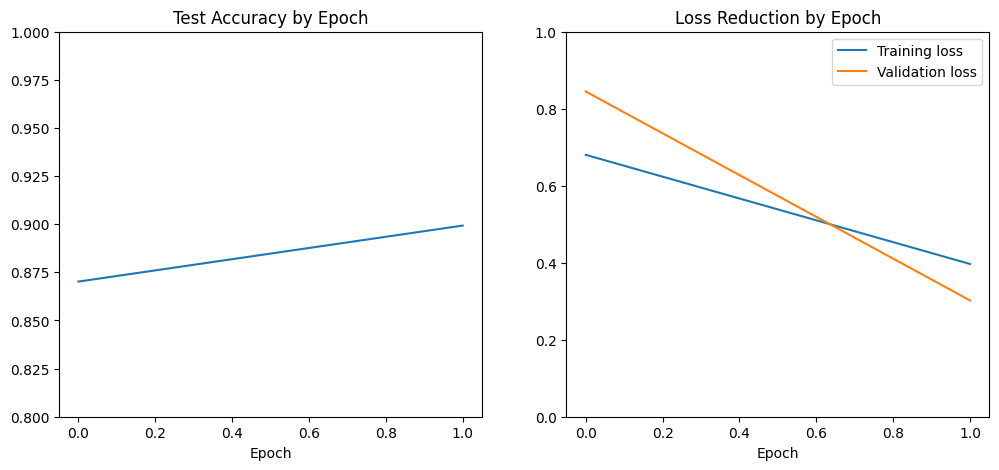

In [29]:
print(" ######################################################### ")
print("Finished training, printing accuracy:")
# Measures the difference between the predicted output and the actual output for a given input.
accuracy_loss_plots(cnn)

In [30]:
print(" ######################################################### ")
print("Evaluating our model:")
# loss is good considering cross-entropy has 0 to infinity loss value range
cnn.evaluate(cnn_x_test,cnn_y_test)

 ######################################################### 
Evaluating our model:
313/313 [==============================] - 5s 15ms/step - loss: 0.3275 - accuracy: 0.8868


[0.32748013734817505, 0.8867999911308289]

In [31]:
print(" ######################################################### ")
#Load in the best model state from ModelCheckpoint
print("Loading our best (saved) model.")
cnn_best = load_model('cnn.h5')
cnn_best

 ######################################################### 
Loading our best (saved) model.


In [32]:
print(" ######################################################### ")
#Confirm loss and accuracy on the test data
print("Evaluating our best model:")
cnn_best.evaluate(cnn_x_test,cnn_y_test)

 ######################################################### 
Evaluating our best model:
313/313 [==============================] - 5s 15ms/step - loss: 0.3275 - accuracy: 0.8868


[0.32748013734817505, 0.8867999911308289]

 ######################################################### 
Confusion matrix
313/313 [==============================] - 5s 16ms/step


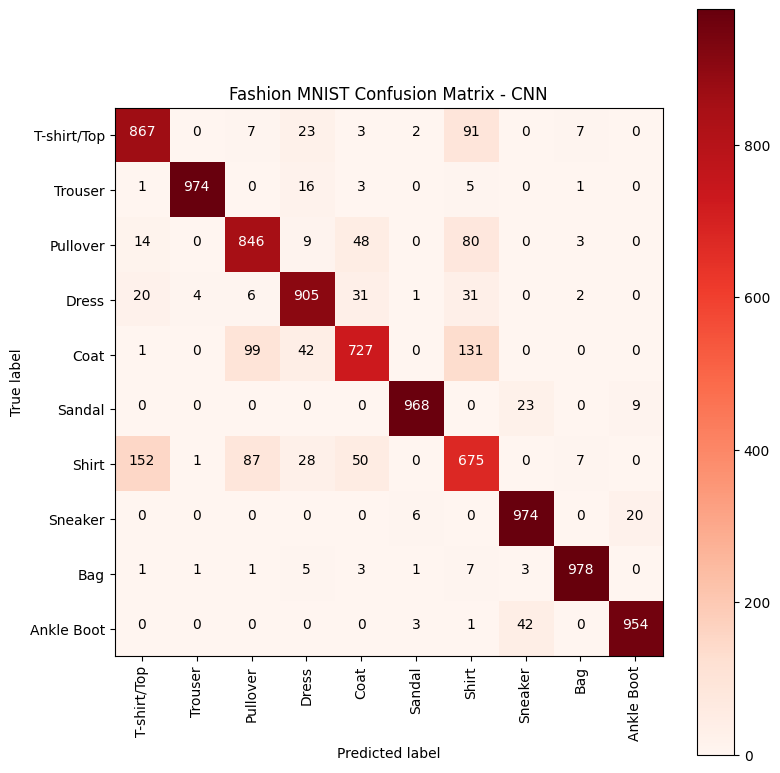

In [33]:
print(" ######################################################### ")
print("Confusion matrix")
get_confusion_matrix(cnn_x_test, cnn_y_test)

In [49]:
"""
-1 tells numpy to infer the number of rows based on the number of elements
and the provided column shape. The (28, 28, 1) tells numpy to reshape
the arrays so that they have 28 rows, 28 columns, and 1 channel. 
This reshaping is likely done to ensure that the data has 
the correct shape to be fed into an autoencoder model

"""
def shape_autoencoder_data():
    ae_x_train = x_train/255
    ae_x_val = x_val/255
    
    ae_x_train = ae_x_train.reshape(-1, 28, 28, 1)
    ae_x_val = ae_x_val.reshape(-1, 28, 28, 1)
    return (ae_x_train, ae_x_val)


In [50]:
def get_sap_noisy_training_set(ae_x_train, ae_x_val):
    noise = augmenters.SaltAndPepper(0.1)
    seq_object = augmenters.Sequential([noise])

    # train and validation noisy
    ae_x_train_n = seq_object.augment_images(ae_x_train * 255) / 255
    ae_x_val_n = seq_object.augment_images(ae_x_val * 255) / 255
    return (ae_x_train_n, ae_x_val_n)


In [51]:
def get_sap_noisy_cnn_data(x_data, y_data):
    
    noise = augmenters.SaltAndPepper(0.1)
    seq_object = augmenters.Sequential([noise])
    
    x_data = x_data.reshape(-1, 28, 28, 1)
    x_data = x_data/255
    y_data = np_utils.to_categorical(y_data, 10)
    
    x_data = seq_object.augment_images(x_data * 255) / 255
    return (x_data, y_data)

In [52]:
def plot_images(data_set, i_start, i_end):
    total = i_end - i_start
    f, ax = plt.subplots(1,total)
    f.set_size_inches(80, 40)
    for i in range(i_start,i_end):
        ax[i-i_start].imshow(data_set[i].reshape(28, 28))
    plt.show()

Plotting training images with indexes, I_START:  7  I_END:  12


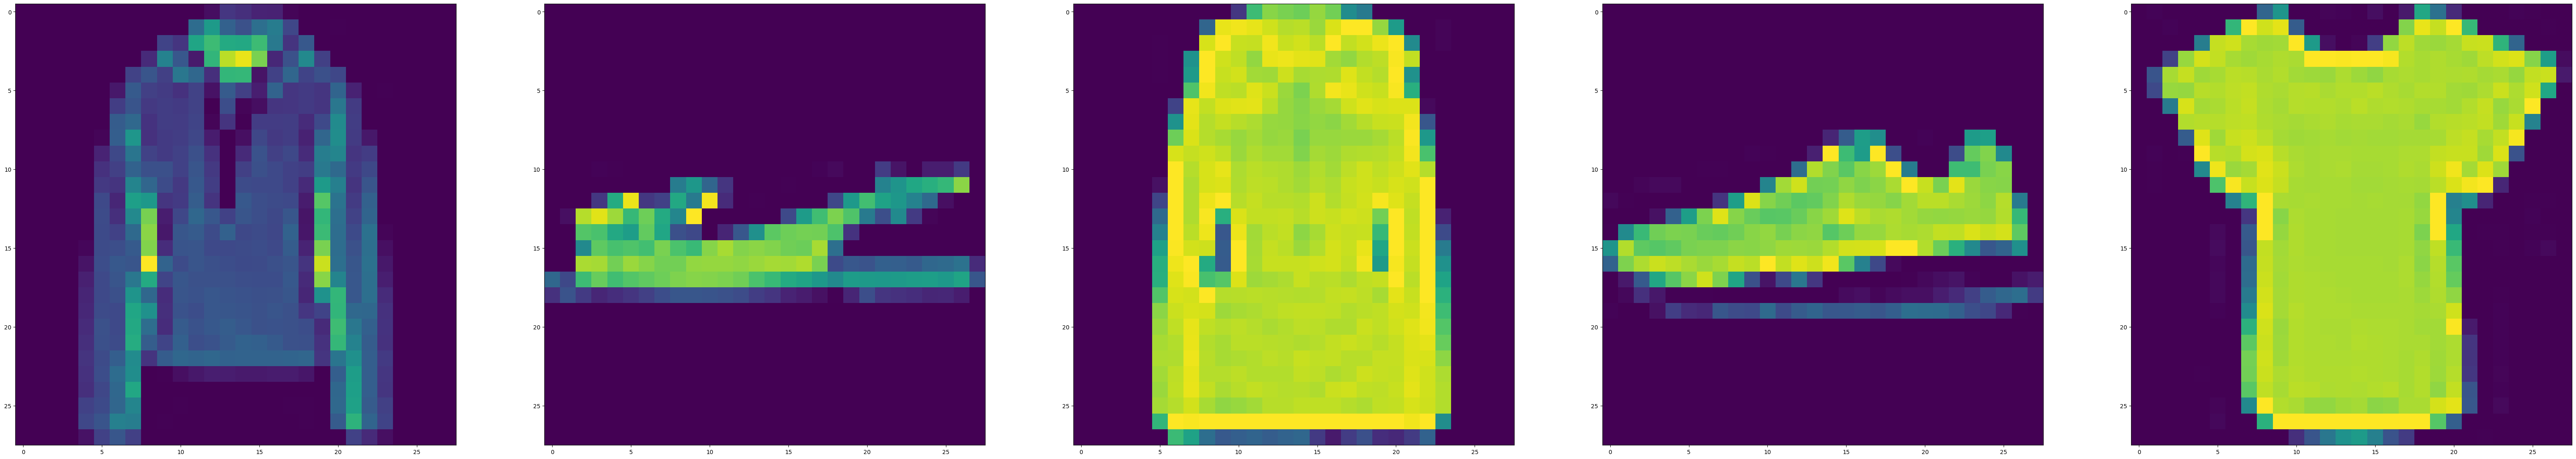

Plotting noisy training images with indexes, I_START:  7  I_END:  12


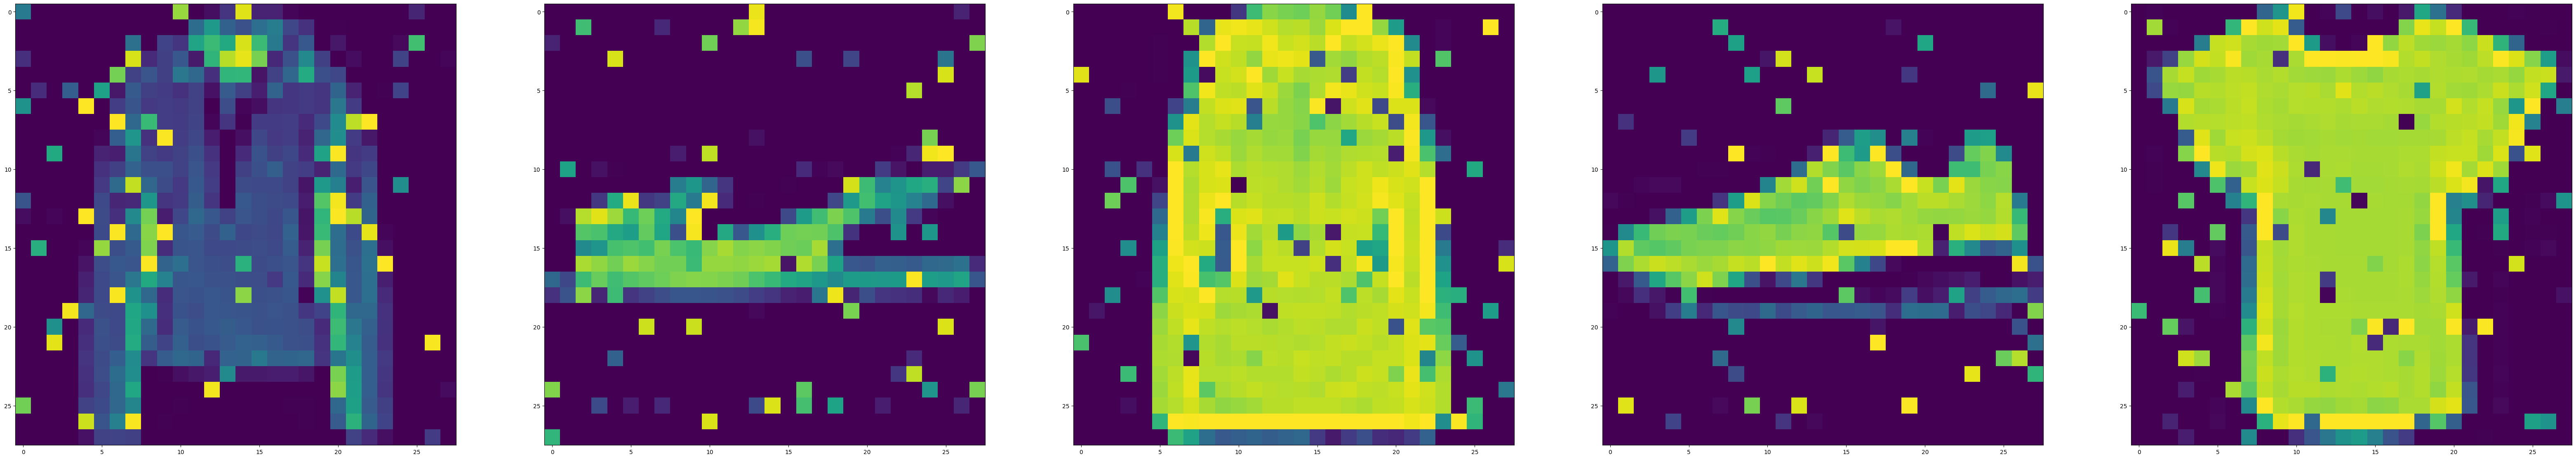

In [56]:
ae_x_train, ae_x_val = shape_autoencoder_data()
ae_x_train_n, ae_x_val_n = get_sap_noisy_training_set(ae_x_train, ae_x_val)

I_START = 7
I_END = 12

print("Plotting training images with indexes, I_START: ", I_START, " I_END: ", I_END)
plot_images(ae_x_train, I_START, I_END)

print("Plotting noisy training images with indexes, I_START: ", I_START, " I_END: ", I_END)
plot_images(ae_x_train_n, I_START, I_END)

In [57]:
"""
Testing cnn with regular testing images and noisy images to see how much difference
"""
x_test_n, y_test_n = get_sap_noisy_cnn_data(x_test, y_test)
cnn_best.evaluate(x_test_n,y_test_n)
cnn_best.evaluate(cnn_x_test, cnn_y_test)

313/313 [==============================] - 5s 16ms/step - loss: 0.3275 - accuracy: 0.8868


[0.32748013734817505, 0.8867999911308289]

In [65]:
def get_autoencoder():
    # input layer 
    input_layer = Input(shape=(28, 28, 1))

    # Encoding Architecture - passing output layer to be input layer of the next layer
    encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    encoded_layer1 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
    encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)


    encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
    encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer2)
    encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
    
    encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
    encoded_layer3 = Conv2D(4, (2, 2), activation='relu', padding='same')(encoded_layer3)

    #latent view is a bottleneck
    latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

    # decoding architecture

    decoded_layer1 = Conv2D(4, (2, 2), activation='relu', padding='same')(latent_view)
    decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded_layer1)
    decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)

    decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
    decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer2)
    decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)

    decoded_layer3 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer2)
    decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer3)
    decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)

    output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)
    return (input_layer, output_layer)
    #dimension of output layer == input layer because we need denoised image 
    # thats why there is no dense layer on

In [66]:
input_layer, output_layer = get_autoencoder() #call autoencoder
model_2 = Model(input_layer, output_layer) # create new model
model_2.compile(optimizer='adam', loss='mse') # prepare for fit
# model_2.summary()
"""
this line of code will stop the training of the model when 
the validation loss stops decreasing by any amount, 
after at least 10 epochs of no improvement, 
it will print the status of the training every 5 epochs,
using the best mode based on the validation data.

"""
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,
                               patience=10, verbose=5, mode='auto')
"""
ae_x_train, 
ae_x_val 

ae_x_train_n, 
ae_x_val_n

"""
history = model_2.fit(
    ae_x_train,
    ae_x_train_n,
    epochs=2, 
    batch_size=2048, # why this size???
    validation_data=(ae_x_val, ae_x_val_n), 
    callbacks=[early_stopping]
)

Epoch 1/2
25/25 [==============================] - 114s 4s/step - loss: 0.1266 - val_loss: 0.0914
Epoch 2/2
25/25 [==============================] - 114s 5s/step - loss: 0.0781 - val_loss: 0.0685


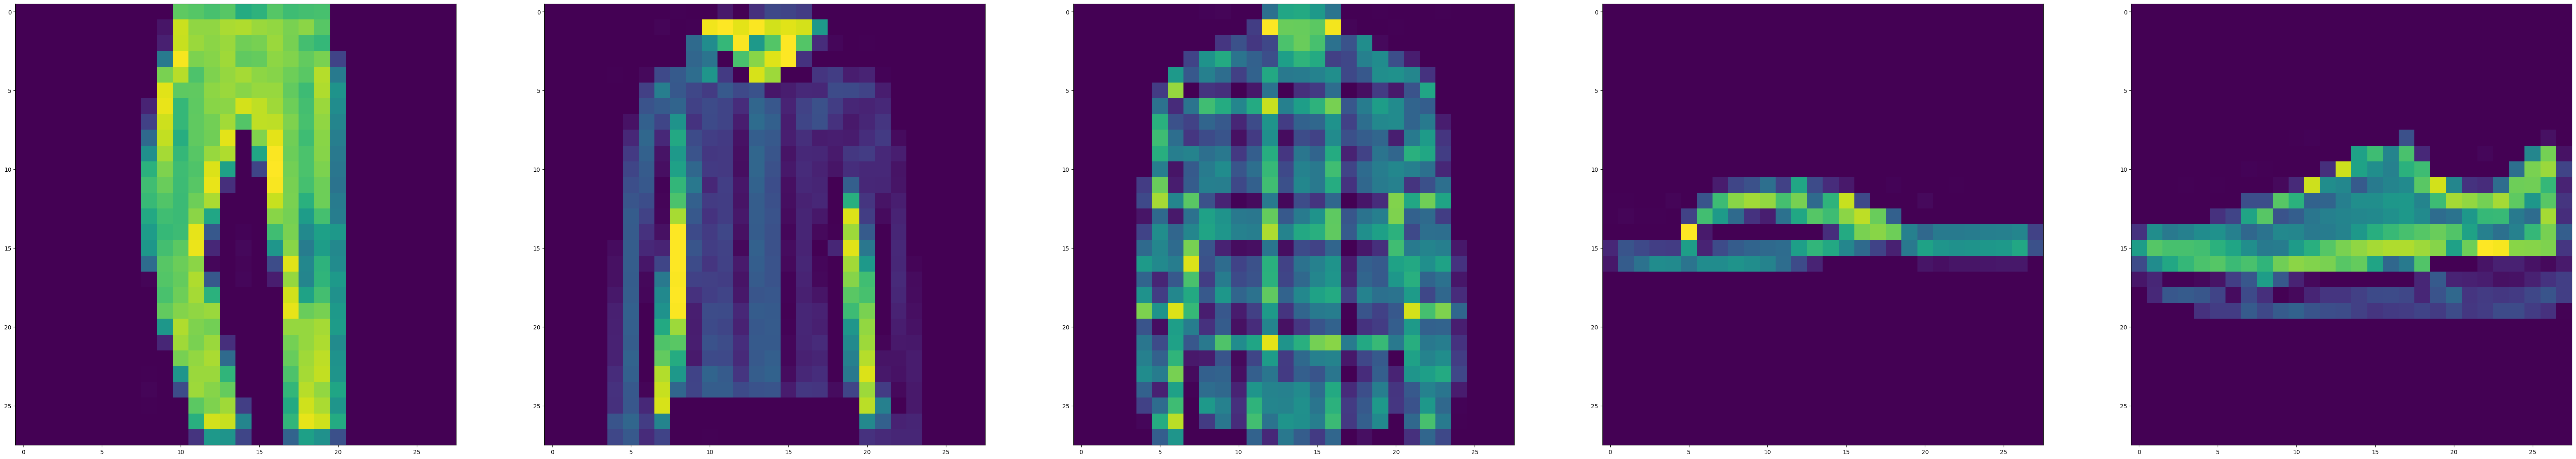

313/313 [==============================] - 6s 19ms/step


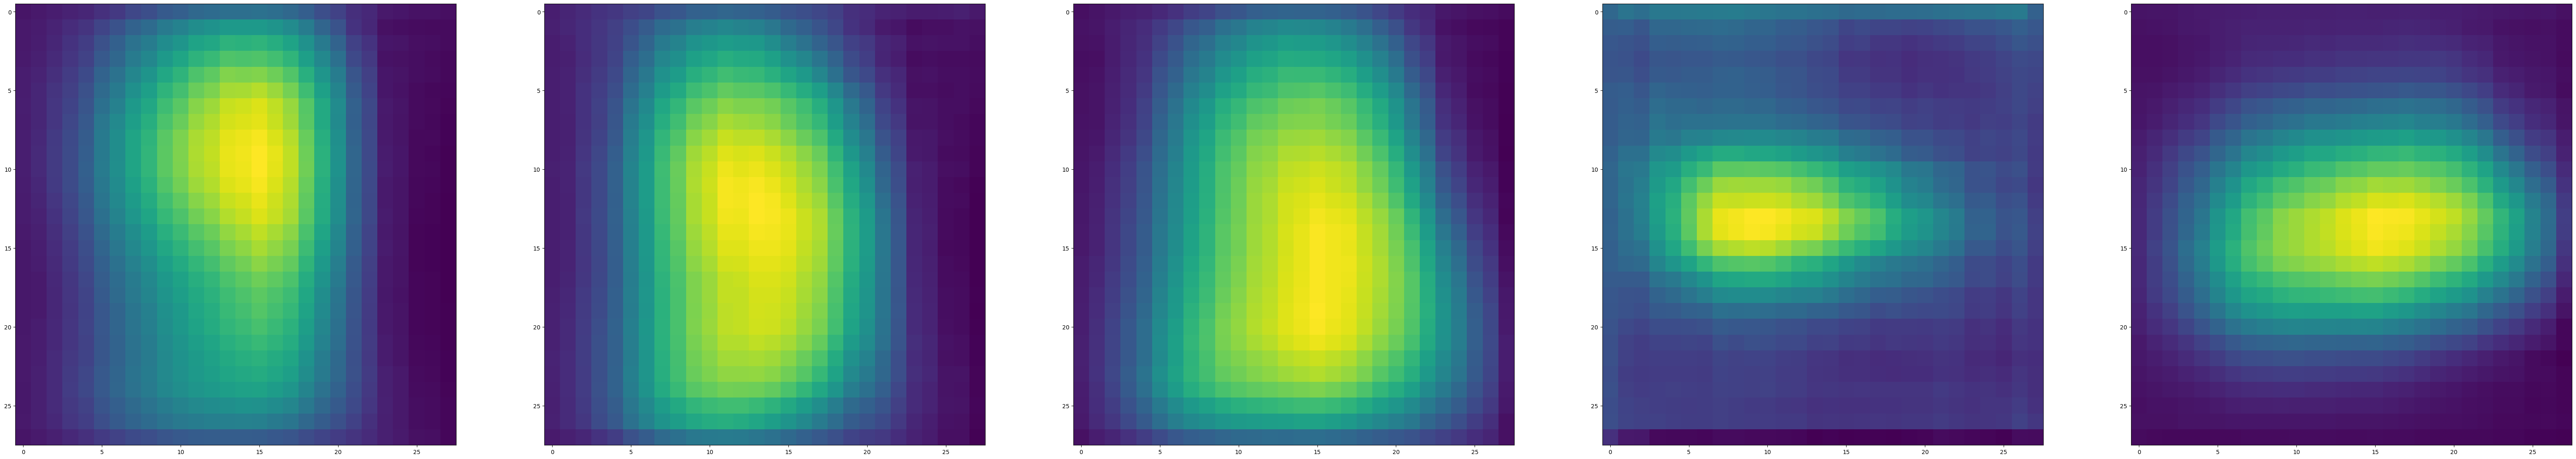

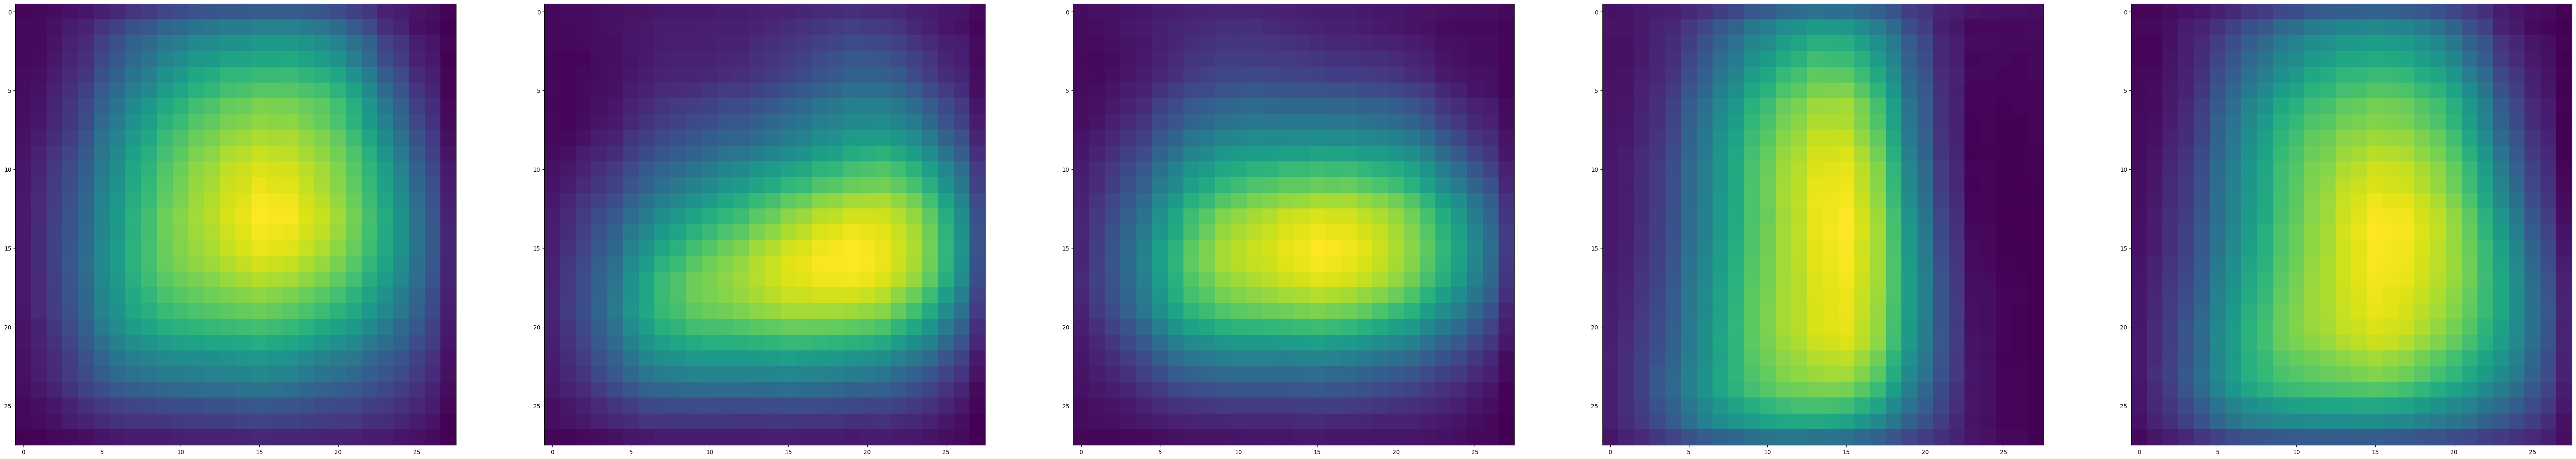

313/313 [==============================] - 6s 19ms/step


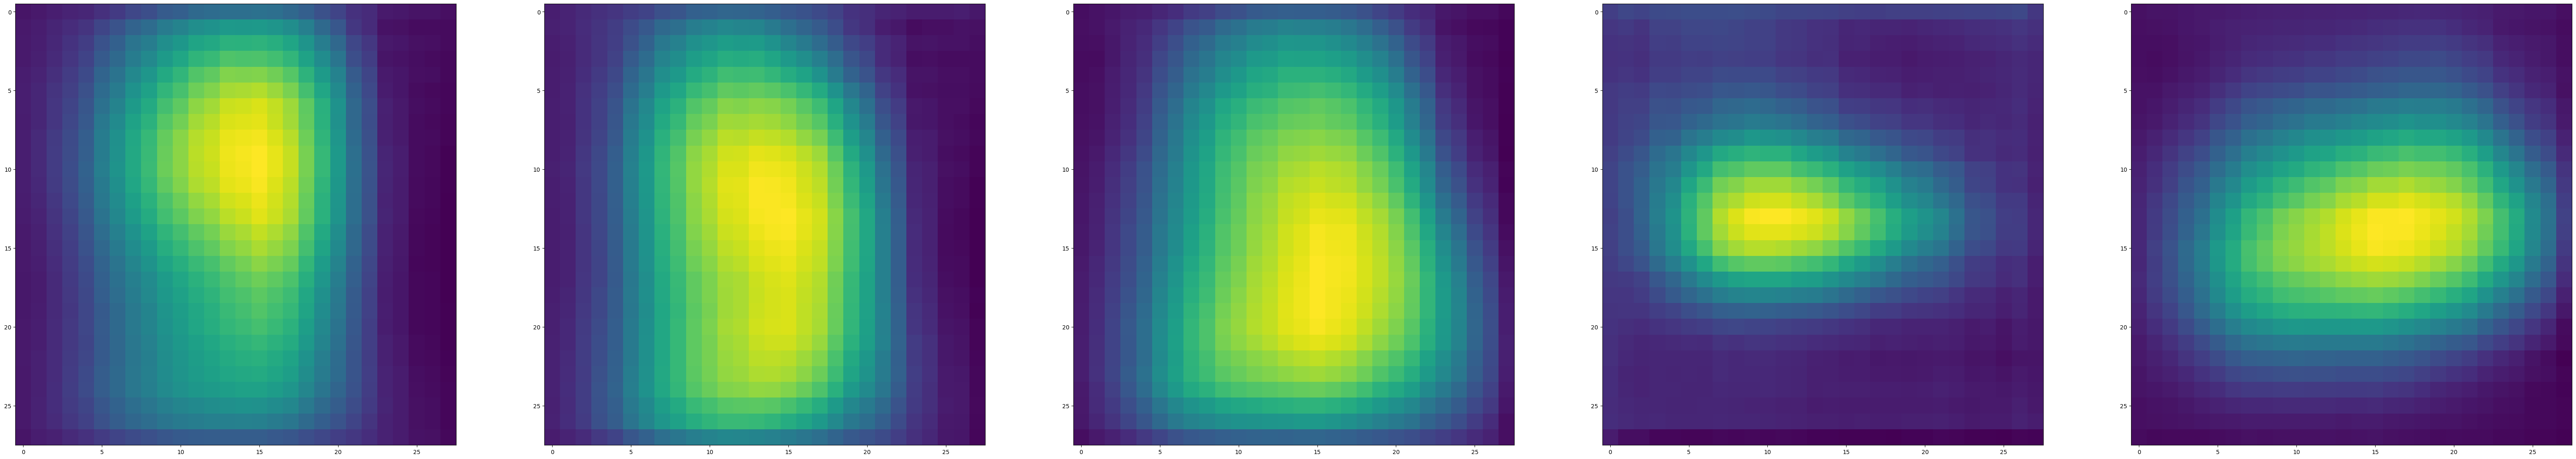

In [82]:
#print("##########################################")
plot_images(cnn_x_test, 5, 10)
#plot_images(cnn_x_test, 10, 15)
#plot_images(cnn_x_test, 15, 20)
#plot_images(cnn_x_test, 300, 305)
#print("##########################################")
# Regular
#TRY PREDICTION ON TEST SET??
ed_x_test = model_2.predict(cnn_x_test)
# Plot
#print("##########################################")
plot_images(ed_x_test, 5, 10)
# plot_images(ed_x_test, 10, 15)
#plot_images(ed_x_test, 15, 20)
#plot_images(ed_x_test, 300, 305)
#print("##########################################")

sappy_x_test, sappy_y_test = get_sap_noisy_cnn_data(x_test, y_test)

# Noisify test images ???
# Noisy test set prediction
ed_x_test_n = model_2.predict(sappy_x_test)
# Plot noisy 10 images with test
plot_images(ed_x_test_n, 5, 10)

In [81]:
cnn_best.evaluate(ed_x_test, cnn_y_test)

313/313 [==============================] - 5s 16ms/step - loss: 2.2514 - accuracy: 0.0889


[2.251358985900879, 0.08889999985694885]

In [76]:
cnn_best.evaluate(ed_x_test_n, cnn_y_test)

313/313 [==============================] - 5s 16ms/step - loss: 2.2710 - accuracy: 0.0812


[2.2709898948669434, 0.0812000036239624]